**# 以多项式回归为例探索过拟合/欠拟合概念**

In [ ]:
!pip install d2l
!pip install matplotlib==3.0

In [3]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

**1. 生成数据集**

* 给定$x$，将**使用以下三阶多项式来生成训练和测试数据的标签：**

**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$**

* 噪声项$\epsilon$服从均值为0且标准差为0.1**的正态分布。在优化的过程中，通常希望避免非常大的梯度值或损失值。这就是将特征从**$x^i$调整为$\frac{x^i}{i!}$的原因，
这样可以避免很大的$i$带来的特别大的指数值。
* 将为训练集和测试集各生成100个样本。
* 特征值数量设置为20。

In [28]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])  

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))   # np.power()用于数组元素求n次方
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

* 同样，存储在`poly_features`中的单项式由gamma函数重新缩放，
其中$\Gamma(n)=(n-1)!$。
从生成的数据集中**查看一下前2个样本**，
第一个值是与偏置相对应的常量特征。

In [29]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.3022],
         [-0.3426]]),
 tensor([[ 1.0000e+00,  3.0220e-01,  4.5662e-02,  4.5997e-03,  3.4751e-04,
           2.1003e-05,  1.0579e-06,  4.5670e-08,  1.7252e-09,  5.7927e-11,
           1.7506e-12,  4.8092e-14,  1.2111e-15,  2.8154e-17,  6.0772e-19,
           1.2244e-20,  2.3125e-22,  4.1108e-24,  6.9016e-26,  1.0977e-27],
         [ 1.0000e+00, -3.4260e-01,  5.8687e-02, -6.7021e-03,  5.7403e-04,
          -3.9333e-05,  2.2459e-06, -1.0992e-07,  4.7073e-09, -1.7919e-10,
           6.1391e-12, -1.9121e-13,  5.4589e-15, -1.4386e-16,  3.5205e-18,
          -8.0409e-20,  1.7218e-21, -3.4698e-23,  6.6043e-25, -1.1909e-26]]),
 tensor([5.1026, 4.4357]))

**2. 对模型进行训练和测试**


* 实现一个函数来评估模型在给定数据集上的损失

In [30]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

* 定义训练函数

In [31]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

**3. 三阶多项式函数拟合(正常)**

* 将首先使用三阶多项式函数，它与数据生成函数的阶数相同。结果表明，该模型能有效降低训练损失和测试损失。学习到的模型参数也接近真实值$w = [5, 1.2, -3.4, 5.6]$。

weight: [[ 5.0007257  1.2002919 -3.3987296  5.603476 ]]


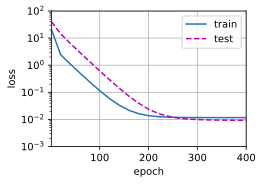

In [32]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

**4. **线性函数拟合(欠拟合)****

* 对于线性函数拟合，减少该模型的训练损失相对困难。在最后一个迭代周期完成后，训练损失仍然很高。当用来拟合非线性模式（如这里的三阶多项式函数）时，线性模型容易欠拟合。

weight: [[4.0011606 4.077702 ]]


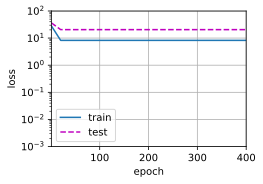

In [44]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

**5. 高阶多项式函数拟合(过拟合)**

* 使用一个阶数过高的多项式来训练模型。在这种情况下，没有足够的数据用于学到高阶系数应该具有接近于零的值。因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响。虽然训练损失可以有效地降低，但测试损失仍然很高。结果表明，复杂模型对数据造成了过拟合。

weight: [[ 5.0030365e+00  1.2048490e+00 -3.4039350e+00  5.5003490e+00
  -7.7934884e-03  7.0910394e-01 -4.9989843e-01 -4.0602091e-01
  -3.4999734e-01 -2.7417430e-01  1.4784031e-01  1.9369020e-01
   1.3129382e-01 -2.1462061e-01 -4.7936202e-03  1.4097616e-01
  -1.9402589e-01  2.1789126e-02  1.8176123e-02  2.1988384e-01]]


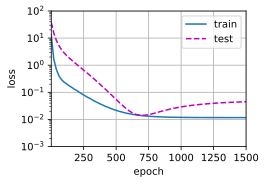

In [45]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)